# Apply correction factor to Voyager data

Note differences from Fraternale analysis

- Much shorter intervals
- Different components (no transformations)

In [1]:
import numpy as np
import pandas as pd
import math as m
import pickle
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as mdates

import sys
import os

sys.path.append(os.path.abspath(".."))
# So that I can read in the src files while working here in the notebooks/ folder

In [2]:
import src.utils as utils
import src.params as params
import src.sf_funcs as sf

# Set matplotlib font size
plt.rc("text", usetex=True)
plt.rc("font", family="serif", serif="Computer Modern", size=10)

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [3]:
def SmoothySpec(a, nums=None):
    """Smooth a curve using a moving average smoothing"""
    b = a.copy()
    if nums is None:
        nums = 2 * len(b) // 3
    for i in range(nums):
        b[i + 1 : -1] = 0.25 * b[i:-2] + 0.5 * b[i + 1 : -1] + 0.25 * b[i + 2 :]
    return b

In [4]:
from sunpy.timeseries import TimeSeries

spacecraft = "voyager"
cadence = "48s"

data = TimeSeries(
    "../data/raw/voyager/voyager1_48s_mag-vim_20110101_v01.cdf",
    concatenate=True,  # Not strictly relevant here as only reading one file at a time
)

df_raw = data.to_dataframe()

df_raw = df_raw.loc[:, params.mag_vars_dict[spacecraft]]

In [5]:
df = df_raw.resample(cadence).mean()

<Axes: >

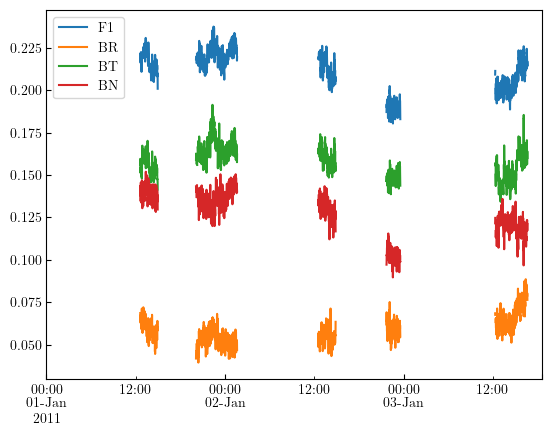

In [6]:
df[:5000].plot()

Getting two derived vars

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

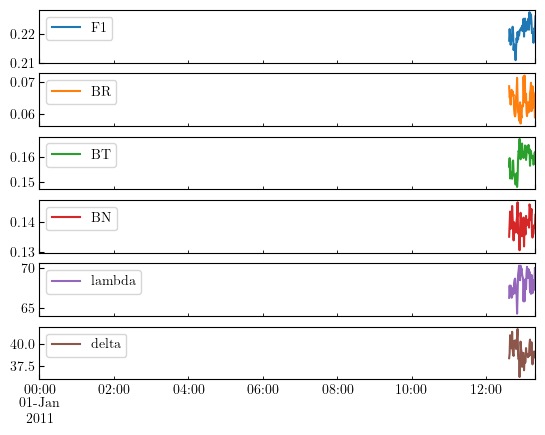

In [7]:
def convert_angle(x):
    if x < 0:
        x += 360
    return x


df["lambda"] = (
    df["BT"].div(df["BR"]).apply(m.atan).apply(m.degrees).apply(convert_angle)
)
df["delta"] = df["BN"].div(df["F1"]).apply(m.asin).apply(m.degrees)

df[:1000].plot(subplots=True)

In [8]:
# Proportion of missing data
print(df.isna().sum() / len(df["F1"]))

F1        0.695021
BR        0.695021
BT        0.695021
BN        0.695021
lambda    0.695021
delta     0.695021
dtype: float64


### Re-creating Fig. 1(a)

In [9]:
# Resample to daily cadence
df_daily = df.resample("D").mean()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

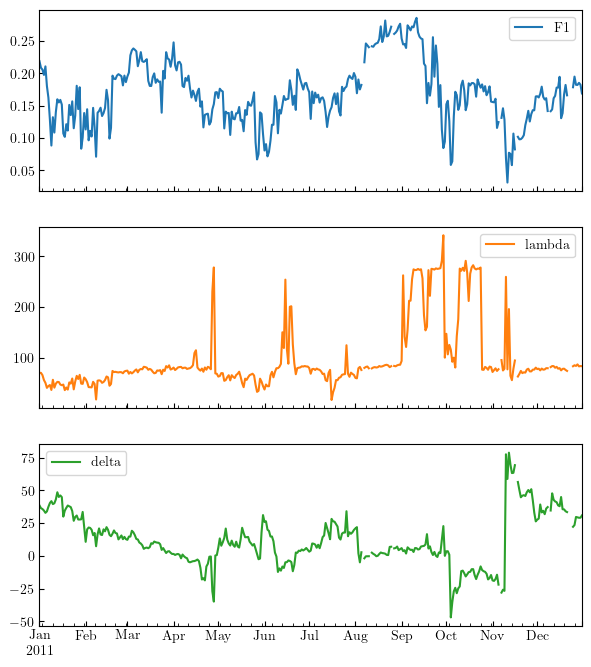

In [10]:
df_daily[["F1", "lambda", "delta"]].plot(subplots=True, figsize=(7, 8))

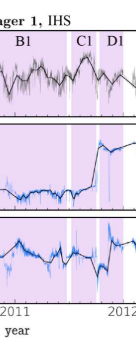

Looks fine, apart from lambda.

Proceeding to extract interval D1 (we won't be using lambda)

In [11]:
# Get DOY 276-365 from the raw data
# subset = df["2021-02-01":"2021-05-01"]
subset = df["2011-10-03":"2011-12-31"]

In [12]:
del df
del df_daily
print(len(subset))

160587


In [13]:
subset.isna().sum() / len(subset)

F1        0.798315
BR        0.798315
BT        0.798315
BN        0.798315
lambda    0.798315
delta     0.798315
dtype: float64

80% data missing

### Computing full SFs

In [14]:
subset_resampled = subset.resample("10min").mean()  # Now only 12,000 long
len(subset_resampled)

12847

In [15]:
# Takes about 20-30 seconds,

sf_full = utils.calc_struct_sdk(
    data=subset_resampled["BT"],
    freq=1 / 600,
    orders=[1, 2, 3, 4],
    max_lag_fraction=0.5,
    plot=False,
)

In [16]:
subset_lint = subset_resampled.interpolate(method="linear")

sf_full_lint = utils.calc_struct_sdk(
    data=subset_lint["BT"],
    freq=1 / 600,
    orders=[1, 2, 3, 4],
    max_lag_fraction=0.5,
    plot=False,
)

### Thresholding procedure
"the computation of $S$ is nontrivial for Voyager data sets due to the amount and distribution of missing data." They do not interpolate, but they do account for the variable reduction in sample size at each lag by applying a threshold of statistical significance as to whether they use certain lags to calculate the slopes

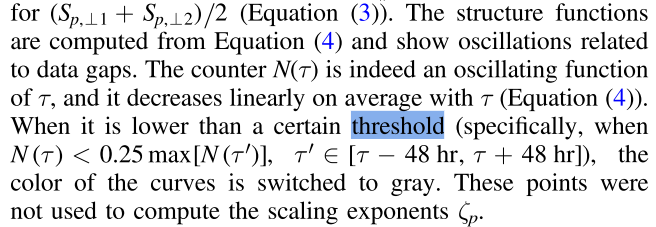

In [17]:
# Define the window size for 48 hours in seconds
# Convert index to time index
sf_full.index = pd.to_timedelta(sf_full.index, unit="s")

window_size = pd.to_timedelta("48h")

# Compute the rolling maximum for a 48-hour window
sf_full["rolling_max"] = (
    sf_full["N"].rolling(window=window_size, min_periods=1, center=True).max()
)

# Compute the threshold
sf_full["threshold"] = 0.25 * sf_full["rolling_max"]

# Determine the color based on the threshold
sf_full["color"] = np.where(sf_full["N"] < sf_full["threshold"], "gray", "black")

# Convert the time index to back to seconds
sf_full.index = sf_full.index.total_seconds()

### Computing correlation scale

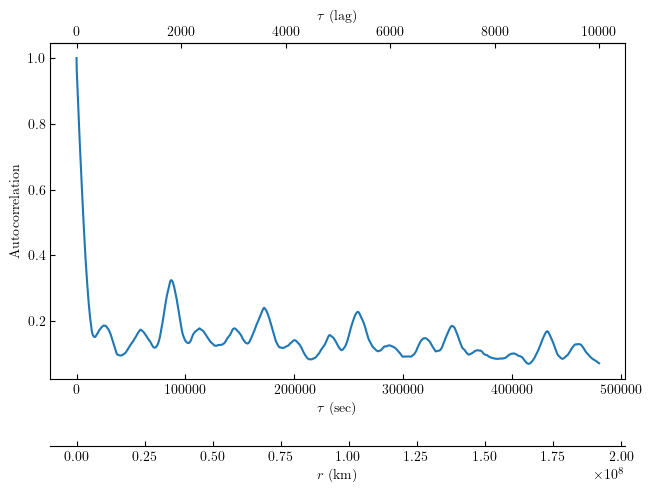

Correlation time = 8694.0s = 2.0 hours


In [18]:
time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [subset.BR, subset.BT, subset.BN],
    nlags=10000,  # Arbritrary large number
    plot=True,
)
tc_exp = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

print(f"Correlation time = {np.round(tc_exp)}s = {np.round(tc_exp/3600)} hours")

Calculating correlation time, using full 60-day dataset. Note highly wiggly ACF due to gaps. 

Also calculating $\lambda_C$ using integral method

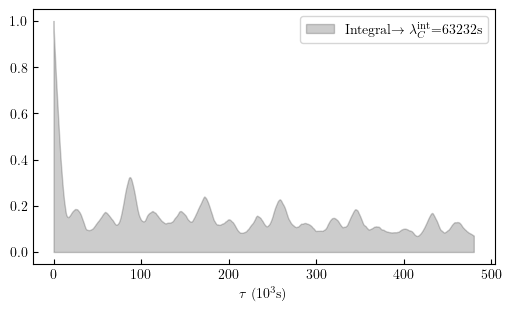

17.5644176343441
hours


In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
tc, fig, ax = utils.compute_outer_scale_integral(time_lags_lr, r_vec_lr, fig, ax, True)
# print(f"Correlation time = {np.round(tc)}s = {np.round(tc/3600)} hours")

plt.show()
print(tc / 60 / 60)
print("hours")

In [20]:
print(
    "10 of these is ",
    np.round(10 * tc / 60 / 60 / 24, 2),
    "days, compared with full data length of",
    subset.index[-1] - subset.index[0],
)

10 of these is  7.32 days, compared with full data length of 89 days 05:08:48


Note that this integral version is much longer, which will make the final interval lengths *slightly* more comparable with Fraternale's ints. (But note in either case the underlying ACF does look a bit silly)

## Computing standardised SFs

i.e. from intervals of 10,000 points across 10 correlation lengths, calculated up to lag 2,000.
Integral corr length `tc` has already been defined above.

In [21]:
tc_n = 10
interval_length = params.int_length
new_cadence = tc_n * tc / interval_length

lags = np.arange(1, params.max_lag_prop * params.int_length)
powers = [2]
file_index = 0
int_index = 0
version = 0

In [22]:
int_std_full = subset.resample(str(np.round(new_cadence, 3)) + "S").mean()
int_std = int_std_full[:10000]

C:\Users\spann\AppData\Local\Temp\ipykernel_18344\675709484.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  int_std_full = subset.resample(str(np.round(new_cadence, 3)) + "S").mean()


In [23]:
len(int_std_full)

121903

In [24]:
del subset

In [25]:
int_norm = utils.normalize(int_std)
bad_input = int_norm[["BR", "BT", "BN"]]

In [26]:
print(bad_input.isna().sum() / len(bad_input["BR"]))
missing = bad_input["BR"].isna().sum() / len(bad_input["BR"])

BR    0.6456
BT    0.6456
BN    0.6456
dtype: float64


In [27]:
bad_output = sf.compute_sf(bad_input, lags, powers, False, False)
bad_output["gap_handling"] = "naive"
bad_output["file_index"] = file_index
bad_output["int_index"] = int_index
bad_output["version"] = version

In [28]:
interp_input = (
    bad_input.interpolate(method="linear").ffill().bfill()
)  # Linearly interpolate (and, in case of missing values at edges, back and forward fill)
interp_output = sf.compute_sf(interp_input, lags, powers, False, False)

In [29]:
bad_input.std()

BR    1.0
BT    1.0
BN    1.0
dtype: float64

In [30]:
interp_input_df = pd.DataFrame(interp_input)
interp_input_df.reset_index(inplace=True)  # Make time a column, not an index

interp_output["file_index"] = 0
interp_output["int_index"] = 0
interp_output["version"] = 0
interp_output["gap_handling"] = "lint"

# Correcting sample size and uncertainty for linear interpolation, same values as no handling
interp_output["n"] = bad_output["n"]
interp_output["missing_percent"] = bad_output["missing_percent"]
interp_output["sf_2_se"] = bad_output["sf_2_se"]

In [31]:
n_bins = 25
run_mode = "full"

sfs_gapped = pd.concat([interp_output, bad_output])

### Correcting SF
**NB: we now have a smoothed version (using method below) that we can import directly**

In [32]:
# Importing lookup table
n_bins = 25
with open(f"../results/{run_mode}/correction_lookup_3d_{n_bins}_bins_lint.pkl", "rb") as f:
    correction_lookup_3d = pickle.load(f)

#### Smooth

Compute scaling, intervals outside of step 4a? Would make this a bit tidier.

### Plot 

In [33]:
# Apply 2D and 3D scaling to test set, report avg errors

sfs_lint_corrected_2d_3d = sf.compute_scaling(
    sfs_gapped, 3, correction_lookup_3d, n_bins
)


correction_wide = sfs_lint_corrected_2d_3d[
    [
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "sf_2_corrected_3d",
    ]
]
correction_long = pd.wide_to_long(
    correction_wide,
    ["sf_2"],
    i=["file_index", "int_index", "version", "lag", "missing_percent"],
    j="gap_handling",
    sep="_",
    suffix=r"\w+",
)
correction_bounds_wide = sfs_lint_corrected_2d_3d[
    [
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "sf_2_lower_corrected_3d",
        "sf_2_upper_corrected_3d",
    ]
]

correction_bounds_long = pd.wide_to_long(
    correction_bounds_wide,
    ["sf_2_lower", "sf_2_upper"],
    i=["file_index", "int_index", "version", "lag", "missing_percent"],
    j="gap_handling",
    sep="_",
    suffix=r"\w+",
)

corrections_long = pd.merge(
    correction_long,
    correction_bounds_long,
    how="inner",
    on=[
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "gap_handling",
    ],
).reset_index()

# Adding the corrections, now as a form of "gap_handling", back to the gapped SF dataframe
sfs_gapped_corrected = pd.concat([sfs_gapped, corrections_long])

Loaded 3D lookup table with 25 bins


In [34]:
sf_corrected_raw = sfs_gapped_corrected.loc[
    (sfs_gapped_corrected["file_index"] == file_index)
    & (sfs_gapped_corrected["int_index"] == int_index)
    & (sfs_gapped_corrected["version"] == version)
    & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
    ["lag", "sf_2"],
]

## Plot of correction + equiv. spectrum

-1.6465189802850988


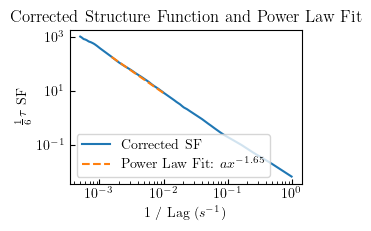

In [35]:
# Fit a power law to the corrected SF
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * x**b


sf_lags = sf_corrected_raw.lag.values
sf_corrected = sf_corrected_raw.sf_2.values
sf_corrected_es = sf_corrected * sf_lags / 6

popt, pcov = curve_fit(power_law, 1 / sf_lags[100:700], sf_corrected_es[100:700])

print(popt[1])

# Plotting the corrected structure function and the power law fit
plt.figure(figsize=(3, 2))
plt.loglog(1 / sf_lags, sf_corrected_es, label="Corrected SF")
plt.loglog(
    1 / sf_lags[100:700],
    power_law(1 / sf_lags[100:700], *popt),
    label=f"Power Law Fit: $a x^{{{popt[1]:.2f}}}$",
    linestyle="--",
)
plt.xlabel("1 / Lag ($s^{-1}$)")
plt.ylabel("$\\frac{1}{6} \\tau$ SF")
plt.title("Corrected Structure Function and Power Law Fit")
plt.legend()
plt.show()

Let's compare with the values for the uncorrected version (JUST LOOK AT SECOND VALUE OF FIRST ARRAY)

In [36]:
# sf_corrected_raw = sfs_gapped_corrected.loc[
#     (sfs_gapped_corrected["file_index"] == file_index)
#     & (sfs_gapped_corrected["int_index"] == int_index)
#     & (sfs_gapped_corrected["version"] == version)
#     & (sfs_gapped_corrected["gap_handling"] == "lint"),
#     ["lag", "sf_2"],
# ]

# sf_corrected = sf_corrected_raw.sf_2.values
# sf_corrected_es = sf_corrected * sf_lags / 6

# curve_fit(power_law, 1 / sf_lags[100:700], sf_corrected_es[100:700])

Text(0, 0.5, '$\\frac{1}{6} \\tau$ SF')

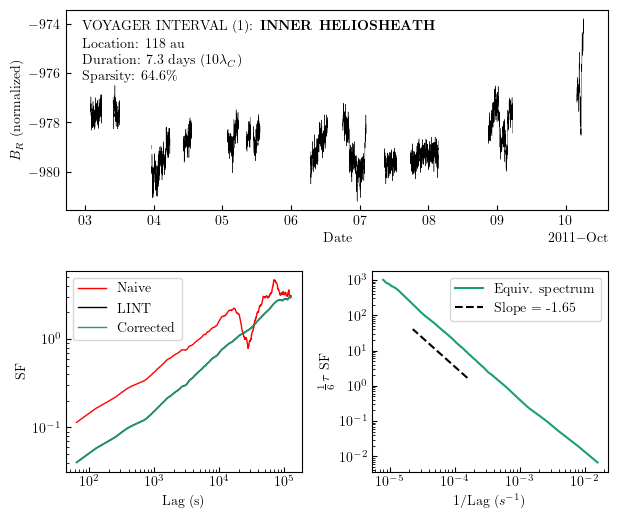

In [37]:
# fig, ax = plt.subplots(1, 3, figsize=(8, 2), constrained_layout=True)
fig = plt.figure(figsize=(7, 6))

gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
gs.update(hspace=0.3, wspace=0.3)  # Change 0.5 to control the spacing
# First row, spanning both columns
ax1 = fig.add_subplot(gs[0, :])

# Second row, first column
ax2 = fig.add_subplot(gs[1, 0])

# Second row, second column
ax3 = fig.add_subplot(gs[1, 1])


file_index = 0
int_index = 0
version = 0

ax1.plot(bad_input.index, bad_input["BR"], color="black", lw=0.3, label="Raw")
# ax1.plot(
#     interp_input_df["Time"],
#     interp_input_df["BR"],
#     color="black",
#     lw=1,
#     label="Linearly interpolated",
# )
ax1.set_xlabel("Date")
ax1.set_ylabel(r"$B_R$ (normalized)")
ax1.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator())
)
# ax1.set_title("Magnetic field @ 154 AU (Voyager 1, interstellar medium)"),
# ax1.set_title("Magnetic field @ 118 AU (Voyager 1, inner heliosheath)")

ax1.annotate(
    f"Location: 118 au\n \
    Duration: {np.round(tc*10/(24*60*60),1)} days ($10\\lambda_C$)\n \
    Sparsity: {float(missing*100):.1f}\%",
    xy=(1, 1),
    xycoords="axes fraction",
    xytext=(0.03, 0.65),  # 0.1 / 0.65
    textcoords="axes fraction",
    transform=ax1.transAxes,
    c="black",
    # bbox=dict(facecolor="lightgrey", edgecolor="white", boxstyle="round", alpha=0.7),
)

ax1.annotate(
    r"VOYAGER INTERVAL (1): \textbf{INNER HELIOSHEATH}",
    xy=(1, 1),
    xycoords="axes fraction",
    xytext=(0.03, 0.9),  # 0.03 / 0.28
    textcoords="axes fraction",
    transform=ax1.transAxes,
    c="black",
    # bbox=dict(facecolor="lightgrey", edgecolor="white", boxstyle="round", alpha=0.7),
)

ax2.set_xlabel("Lag (s)")
ax2.set_ylabel("SF")

ax2.plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "naive"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "naive"),
        "sf_2",
    ],
    color="red",
    lw=1,
    label="Naive",
)
ax2.plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "lint"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "lint"),
        "sf_2",
    ],
    color="black",
    lw=1,
    label="LINT",
)
ax2.plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2",
    ],
    color="#1b9e77",
    lw=1,
    label="Corrected",
)
ax2.fill_between(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2_lower",
    ],
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2_upper",
    ],
    color="#1b9e77",
    alpha=0.2,
)
ax2.legend(loc="upper left")  # lower right
ax2.semilogx()
ax2.semilogy()

# Third panel (bottom right)
ax3.plot(
    1 / (sf_lags * new_cadence),
    sf_corrected_es,
    label="Equiv. spectrum",
    c="#1b9e77",
)
ax3.plot(
    1 / (sf_lags[100:700] * new_cadence),
    power_law(1 / sf_lags[100:700], *popt) / 5,
    label="Slope = {:.2f}".format(popt[1]),
    ls="--",
    color="black",
)
ax3.semilogx()
ax3.semilogy()
ax3.legend(loc="upper right")
ax3.set_xlabel("1/Lag ($s^{-1}$)")
ax3.set_ylabel(r"$\frac{1}{6} \tau$ SF")
# plt.savefig("plots/results/final/voyager_ihs.pdf")